## PTM structural context
#### Last updated 2022-08-24

The notebook here contains a global analysis of post-translational modifications across the human proteome investigating their structural contexts.

## Data used
This notebook uses several different sources for data annotations.

#### A comment on structural classication
Structural classification is done using AlphaFold2 predicted structures followed by per-residue structural classiciation using DISICL, as described by Nagy et al. 2014. DISICL predictions were made using a module taken from the SESCA (Nagy et al. 2019).

#### A comment on the predicted intrinsically disordered regions
The disordered regions identified here were predicted using [metapredict V2](https://www.biorxiv.org/content/10.1101/2022.06.06.494887v1), a recent update to our [metapredict](http://dx.doi.org/10.1016/j.bpj.2021.08.039) disorder predictor. For insight into how this works and the potential caveats, please see the associated papers or the [metapredict documentation](https://metapredict.readthedocs.io/).

#### A comment on the post-translational modification (PTM) data
PTM data were downloaded from [proteome scout](https://proteomescout.wustl.edu/compendia), an online database that combines a wide array of different PTM databases generating a convenient single source for PTM data. The annotations of these sites as being IDR-located (or not) was done in the `PTM_af2_analysis` directory associated with this sub-repository. 


### Publication references

Jumper, J., Evans, R., Pritzel, A., Green, T., Figurnov, M., Ronneberger, O., Tunyasuvunakool, K., Bates, R., Žídek, A., Potapenko, A., Bridgland, A., Meyer, C., Kohl, S. A. A., Ballard, A. J., Cowie, A., Romera-Paredes, B., Nikolov, S., Jain, R., Adler, J., … Hassabis, D. (2021). Highly accurate protein structure prediction with AlphaFold. Nature, 596(7873), 583–589.

Tunyasuvunakool, K., Adler, J., Wu, Z., Green, T., Zielinski, M., Žídek, A., Bridgland, A., Cowie, A., Meyer, C., Laydon, A., Velankar, S., Kleywegt, G. J., Bateman, A., Evans, R., Pritzel, A., Figurnov, M., Ronneberger, O., Bates, R., Kohl, S. A. A., … Hassabis, D. (2021). Highly accurate protein structure prediction for the human proteome. Nature, 596(7873), 590–596.

Nagy, G., & Oostenbrink, C. (2014). Dihedral-based segment identification and classification of biopolymers I: proteins. Journal of Chemical Information and Modeling, 54(1), 266–277.

Nagy, G., Igaev, M., Jones, N. C., Hoffmann, S. V., & Grubmüller, H. (2019). SESCA: Predicting Circular Dichroism Spectra from Protein Molecular Structures. Journal of Chemical Theory and Computation, 15(9), 5087–5102.

Emenecker, R. J., Griffith, D., & Holehouse, A. S. (2021). Metapredict: a fast, accurate, and easy-to-use predictor of consensus disorder and structure. Biophysical Journal, 120(20), 4312–4319.

Emenecker, R. J., Griffith, D., & Holehouse, A. S. (2022). Metapredict V2: An update to metapredict, a fast, accurate, and easy-to-use predictor of consensus disorder and structure. In bioRxiv (p. 2022.06.06.494887). https://doi.org/10.1101/2022.06.06.494887

Holehouse, A. S., & Naegle, K. M. (2015). Reproducible Analysis of Post-Translational Modifications in Proteomes--Application to Human Mutations. PloS One, 10(12), e0144692.

Matlock, M. K., Holehouse, A. S., & Naegle, K. M. (2015). ProteomeScout: a repository and analysis resource for post-translational modifications and proteins. Nucleic Acids Research, 43(Database issue), D521–D530.

In [1]:
###
### PLOTTING SETTINGS ####
###

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

# list of PTMs we're going to explore in this analysis
ptms_of_interest = ['Phosphoserine', 'Phosphothreonine', 'Phosphotyrosine', 'Ubiquitination', 'N6-acetyllysine', 'N-Glycosylation', 
 'Methylation', 'Sumoylation', 'Dimethylation', 'O-Glycosylation', 'Omega-N-methylarginine',  'N6-succinyllysine',
 'N-acetylalanine', 'N-acetylmethionine', 'S-nitrosocysteine', 'N6,N6-dimethyllysine', 'Asymmetric dimethylarginine']


In [2]:
# import 
import pandas as pd 
import numpy as np

import shephard
from shephard.apis import uniprot, fasta
from shephard.interfaces import si_domains, si_tracks, si_proteins, si_sites
from shephard.tools import domain_tools, sequence_tools

### DISICL classification

The codes here map the mapping between structural classification integer codes and the type of local structure

In [3]:
# mapping of integer codes to short-name for structural features
DISICL_TYPES = list(enumerate(['3H', 'ALH', 'PIH', 'EBS', 'NBS', 'PP', 'TI', 'TII', 'TVIII', 'GXT', 
                'SCH', 'HP', 'TC', 'HC', 'BC', 'BU', 'LTII', 'LHH', 'UC']))

# ordered list of structural features 
DISICL_NAMES = ['3/10-helix',
                'alpha-helix',
                'pi-helix',
                'Extended beta-strand',
                'Normal beta-strand',
                'Polyproline helix',
                'turn type 1',
                'turn type 2',
                'turn type 8',
                'gamma turns',
                'Schellman turn',
                'hairpin',
                'turn-cap',
                'helix-cap',
                'beta cap',
                'beta bulge',
                'left turn 2',
                'left-handed helix',
                'Uncharacterized']


### Read in Data
The first thing we do is read in data.

Here we read in the human proteome as a SHEPHARD proteins file, and then add AlphaFold2-derived binding accessibility scores, intrinsically disordered regions, and finally, PTMs.


In [4]:
print('Reading in human proteome...')
af2_prot = shephard.proteome.Proteome([])
si_proteins.add_proteins_from_file(af2_prot,'../shprd_data/shprd_proteins_filtered_human_af2_f1acc.tsv')

print('Reading in all structural classicaitions')
si_tracks.add_tracks_from_file(af2_prot, '../shprd_data/shprd_tracks_DISICL_human.tsv', mode='values')

print('Reading in all IDRs...')

# si_domains.add_domains_from_file(af2_prot, '../shprd_data/shprd_domains_human_IDRs_0.420.tsv') # metapredict1 IDRS
si_domains.add_domains_from_file(af2_prot, '../shprd_data/shprd_domains_idrs_metapredict_v2.tsv' ) # metapredict2 IDRS

print('Reading in all PTMs...')
si_sites.add_sites_from_file(af2_prot, '../generated_data/shprd_sites_ptms_with_idr_and_accessibility_attributes.tsv')

Reading in human proteome...
Reading in all structural classicaitions
Reading in all IDRs...
Reading in all PTMs...


In [5]:
# get all Site objects that match the ptms of interest
relevant_sites = af2_prot.get_sites_by_type(ptms_of_interest)

# generate a second list of Site objects that are not found in IDRs (i.e. are in in)
# predicted folded domains
relevant_sites_in_fds = []
for site in relevant_sites:
    if 'in_IDR' not in site.attributes:
        relevant_sites_in_fds.append(site)
        
# print a summary statistic        
print(f"There are {len(relevant_sites)} PTM sites across the human proteome that match our sites of interest")        
print(f"There are {len(relevant_sites_in_fds)} PTM sites in folded domains across the human proteome that match our sites of interest")        

There are 323148 PTM sites across the human proteome that match our sites of interest
There are 165391 PTM sites in folded domains across the human proteome that match our sites of interest


### Map structural contexts to PTM sites
The code below generates two dictionaries, for each dictionary each type of PTM is mapped to one of 19 different integer codes that reflect different structural contexts. These structural contexts are taken from the `DISICL` track.

In [6]:
ptmtype_to_context = {}
ptmtype_to_context_fds = {}

# for each site in the list of sites which we care about (defined by ptms_of_interest)
for site in relevant_sites:
    
    # if we have yet to see this ptm type...
    if site.site_type not in ptmtype_to_context:
        
        # initialy this key-value pair in the dictionary
        ptmtype_to_context[site.site_type] = []
        ptmtype_to_context_fds[site.site_type] = []
        
    # all for the site extract the DISICL code associated with that residue
    ptmtype_to_context[site.site_type].append(int(site.get_track_value('DISICL')))
    
    # do same thing for residues only in folded domains 
    if 'in_IDR' not in site.attributes:
        ptmtype_to_context_fds[site.site_type].append(int(site.get_track_value('DISICL')))
        
    

In [7]:
# Finally, we generate a sorted list of ptm type names sorted by their abundance
ptmtype_to_context = dict(sorted(ptmtype_to_context.items(), key=lambda item: len(item[1]),reverse=True))
sorted_names = list(ptmtype_to_context.keys())
ptm_counts_all = []
ptm_counts_fd = []

for ptm_name in  sorted_names:
    ptm_counts_all.append(len(ptmtype_to_context[ptm_name]))
    ptm_counts_fd.append(len(ptmtype_to_context_fds[ptm_name]))


### Make counts figure
Make figure showing counts in all proteins contexts and in folded domains only

meta NOT subset; don't know how to subset; dropped


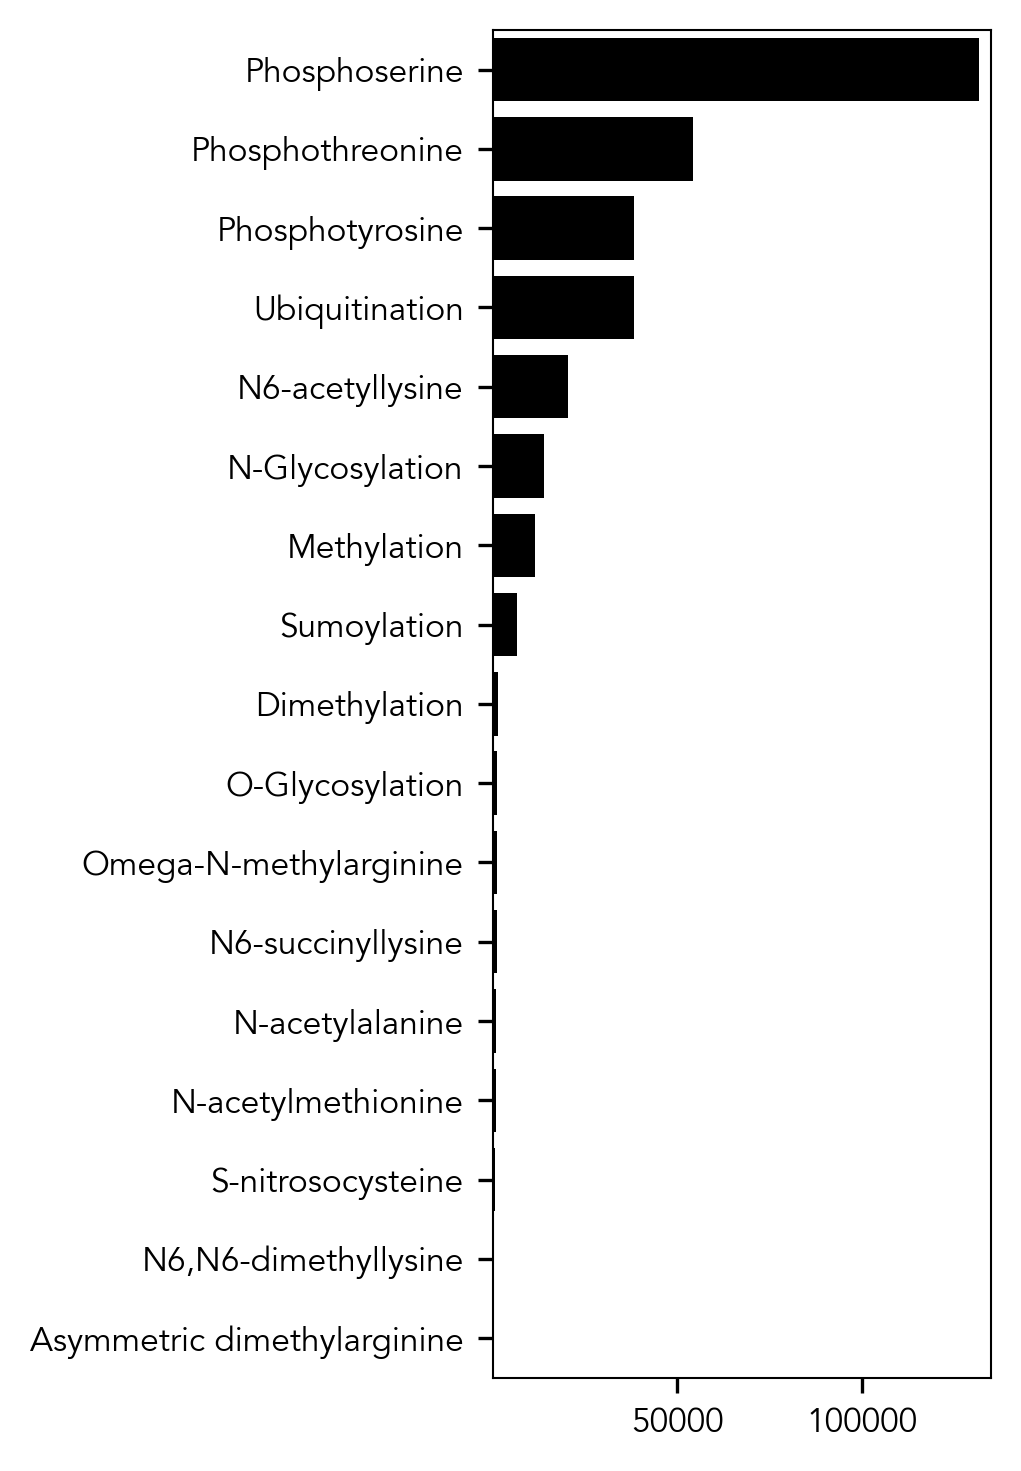

In [44]:
fig = figure(num=None, figsize=(3.5, 5), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.barh(np.arange(0,len(ptm_counts_all)), ptm_counts_all[::-1], color='k')
plt.yticks(np.arange(0,len(ptm_counts_all)), sorted_names[::-1],fontsize=8)
plt.xticks(fontsize=8)
plt.ylim([-0.5,16.5])
print('')
#plt.xscale('log')
plt.xlim([100,135000])
plt.tight_layout()
plt.savefig('../FIGURES/PTM_counts_all.pdf')

meta NOT subset; don't know how to subset; dropped


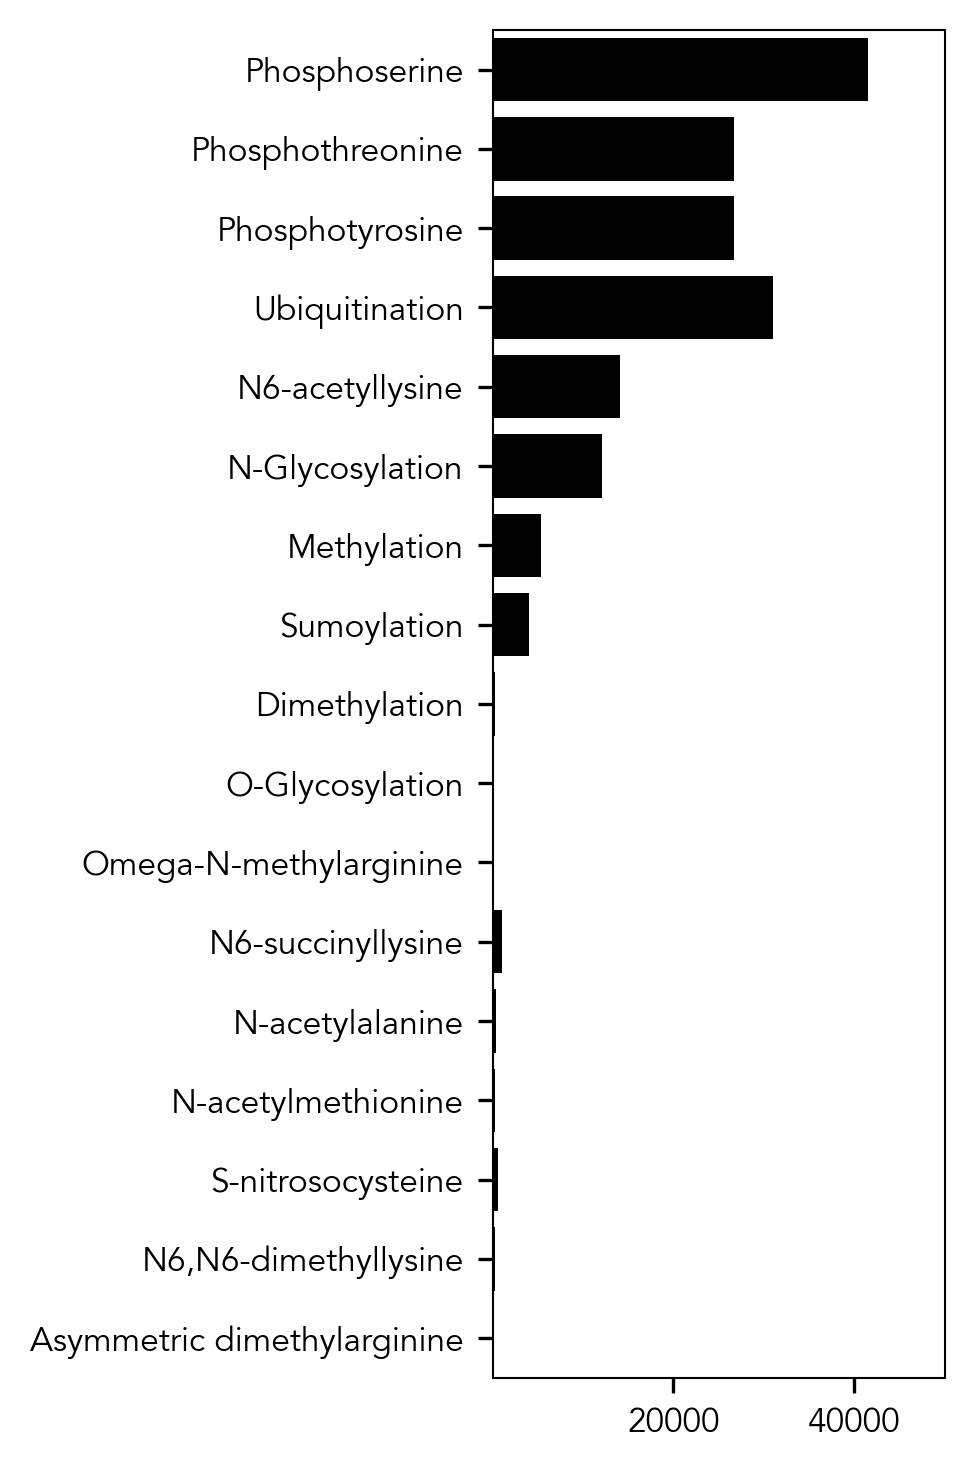

In [45]:
fig = figure(num=None, figsize=(3.5, 5), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.barh(np.arange(0,len(ptm_counts_fd)), ptm_counts_fd[::-1], color='k')
plt.yticks(np.arange(0,len(ptm_counts_fd)), sorted_names[::-1],fontsize=8)
plt.xticks(fontsize=8)
plt.ylim([-0.5,16.5])
print('')
plt.xlim([100,50000])
plt.tight_layout()
plt.savefig('../FIGURES/PTM_counts_fd_only.pdf')

### Construstruct fraction context matrices
The final stage involves taking each type of PTM and counting how many times that PTM is found in each of the 19 possible structural classification types defined by DISICL. We do this for all PTMs and for PTMs found in folded domains.

In [10]:
structural_contexts_all = []
structural_contexts_fd = []

# for each type of ptm
for ptm_name in sorted_names:
    
    # 
    structural_contexts_all.append(np.histogram(ptmtype_to_context[ptm_name],bins=list(range(0,20)))[0]/len(ptmtype_to_context[ptm_name]))
    structural_contexts_fd.append(np.histogram(ptmtype_to_context_fds[ptm_name],bins=list(range(0,20)))[0]/len(ptmtype_to_context_fds[ptm_name]))
    
    

### Make structural context heatmap
Finally, based on the matrices defined above, we generate a heatmap that shows what fraction of PTMs are found in each of the different structural contexts

meta NOT subset; don't know how to subset; dropped


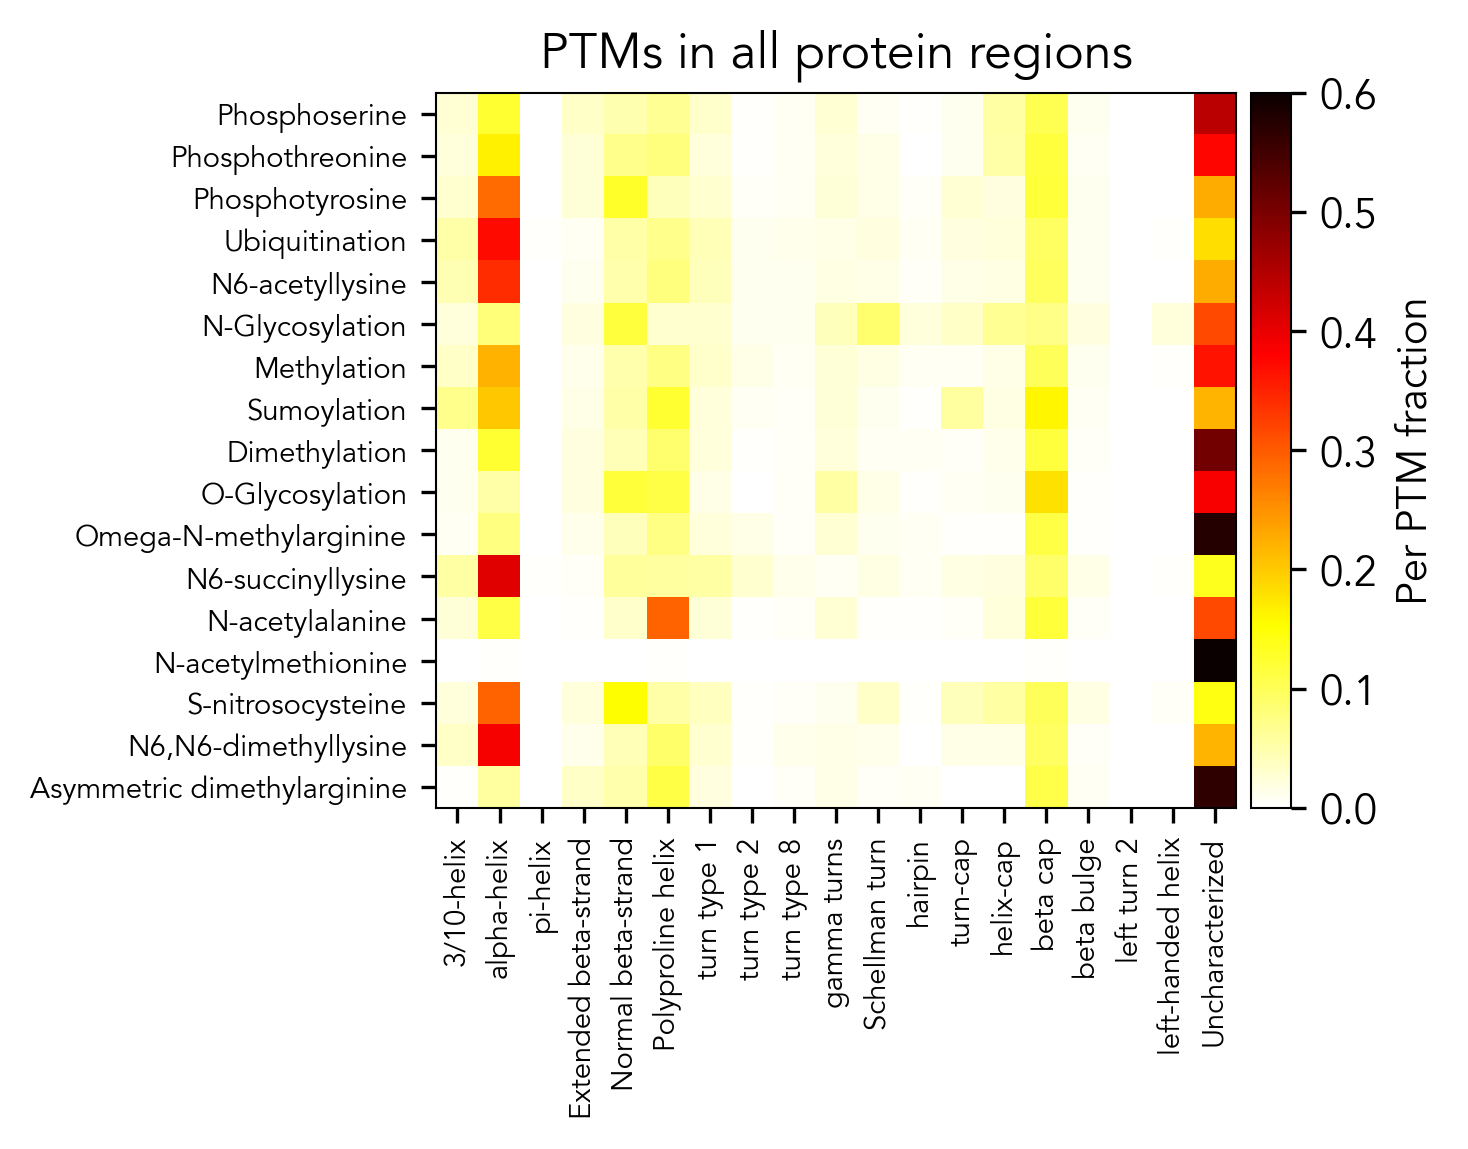

In [11]:
fig = figure(num=None, figsize=(5, 5), dpi=150, facecolor='w', edgecolor='k')
ax_list = fig.axes

plt.imshow(np.array(structural_contexts_all), cmap='hot_r')
plt.xticks(range(0,19), DISICL_NAMES, rotation=90,fontsize=7)
plt.yticks(range(0,len(sorted_names)),sorted_names, fontsize=7)
plt.clim([0,0.6])
plt.title('PTMs in all protein regions')


ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label('Per PTM fraction')


plt.tight_layout()
plt.savefig('../FIGURES/ptms_structural_context_all.pdf')

meta NOT subset; don't know how to subset; dropped


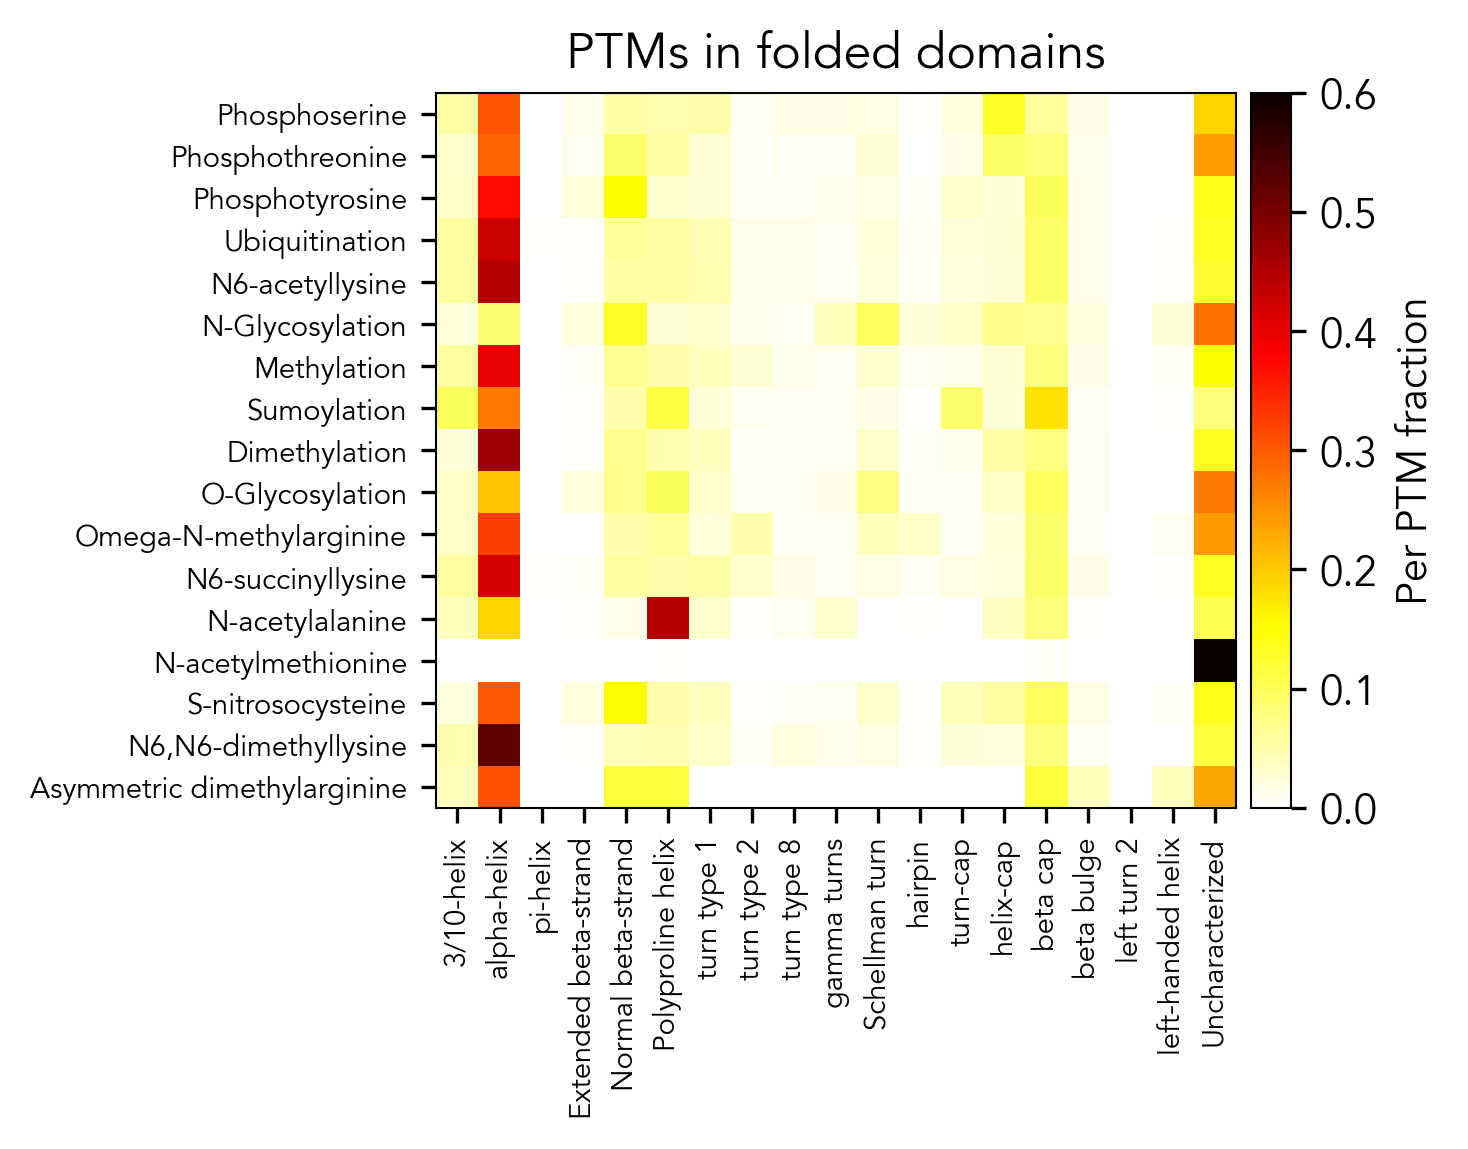

In [12]:
fig = figure(num=None, figsize=(5, 5), dpi=150, facecolor='w', edgecolor='k')
ax_list = fig.axes

plt.imshow(np.array(structural_contexts_fd), cmap='hot_r')
plt.xticks(range(0,19), DISICL_NAMES, rotation=90,fontsize=7)
plt.yticks(range(0,len(sorted_names)),sorted_names, fontsize=7)
plt.clim([0,0.6])
plt.title('PTMs in folded domains')


ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label('Per PTM fraction')


plt.tight_layout()
plt.savefig('../FIGURES/ptms_structural_context_fd.pdf')

meta NOT subset; don't know how to subset; dropped


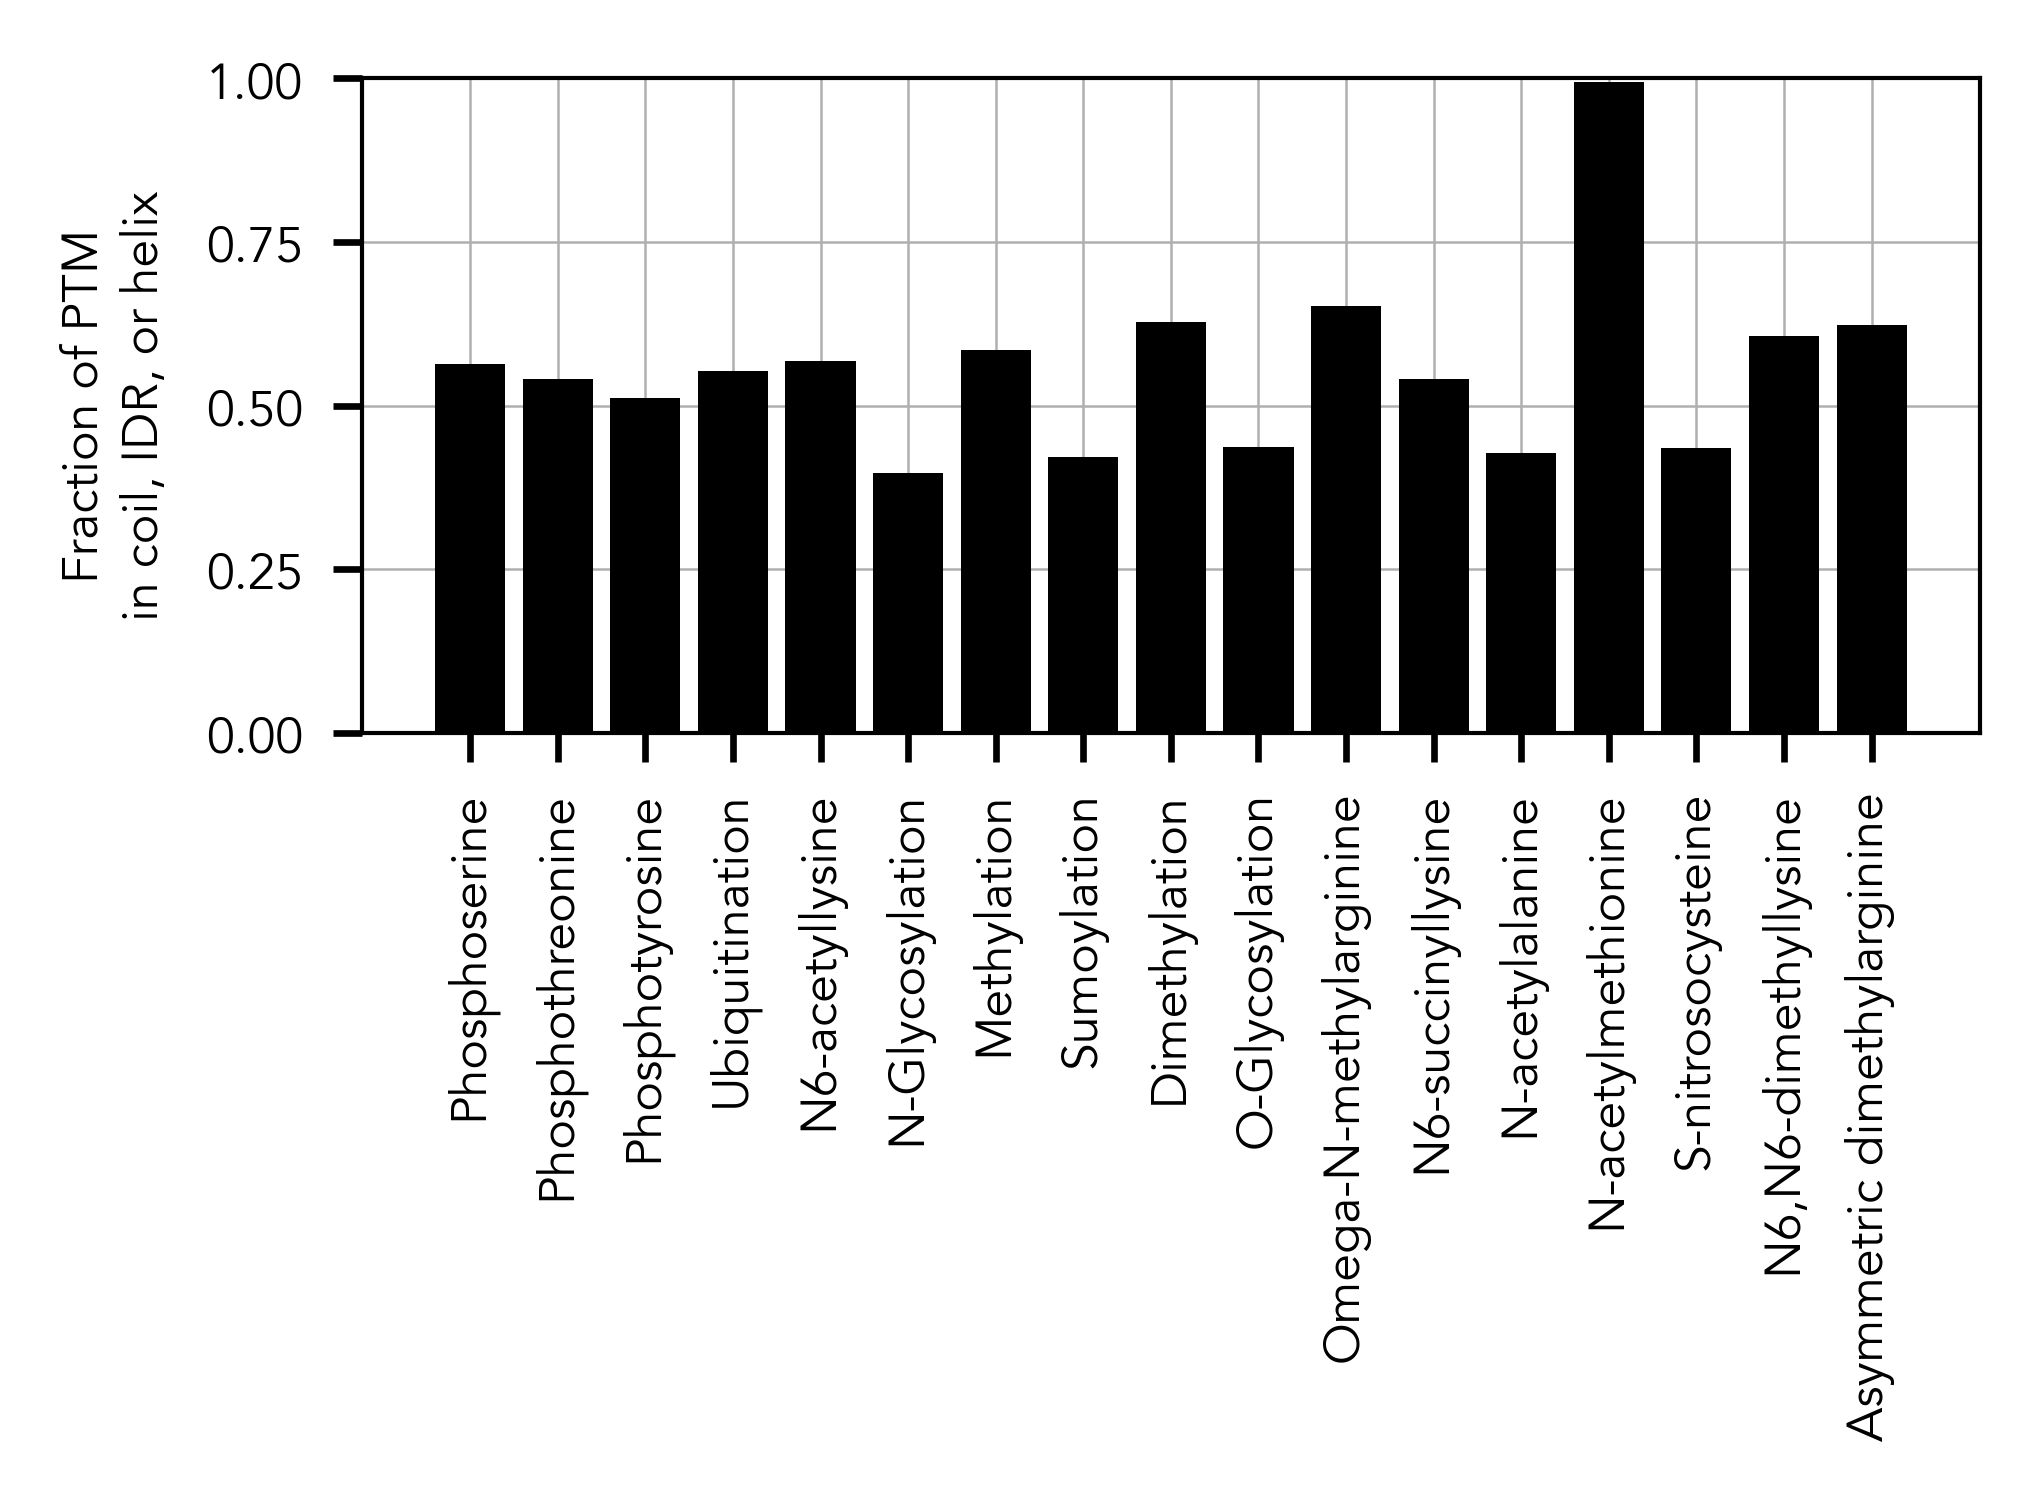

In [13]:
figure(None, (3.5,2.6), dpi=300)
plt.grid(zorder=-300, linewidth=0.3)
plt.bar(np.arange(0,len(ptms_of_interest)), np.array(structural_contexts_all).transpose()[1]+np.array(structural_contexts_all).transpose()[18], color='k', zorder=2)

plt.xticks(np.arange(0,len(ptms_of_interest)), ptms_of_interest,rotation=90, fontsize=6)
print('')
plt.ylabel('Fraction of PTM\nin coil, IDR, or helix', fontsize=6)
plt.yticks([0,0.25,0.5,0.75,1.0],fontsize=6)
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('../FIGURES/PTM_structural_context_helix_or_loop.pdf')




In [14]:
DISICL_counts = np.zeros(19)

In [15]:
for protein in af2_prot:
    for idx in [int(i) for i in protein.track('DISICL').values]:
        DISICL_counts[idx] = DISICL_counts[idx] + 1
        
DISICL_counts        

array([ 390034., 3069905.,   16816.,  172594.,  780491.,  713142.,
        329677.,   74636.,   92774.,  213367.,  218451.,   75120.,
        176805.,  375975.,  961236.,  108757.,   17705.,   23137.,
       2672725.])

In [16]:
DISICL_counts = np.array(DISICL_counts)/np.sum(DISICL_counts)

meta NOT subset; don't know how to subset; dropped


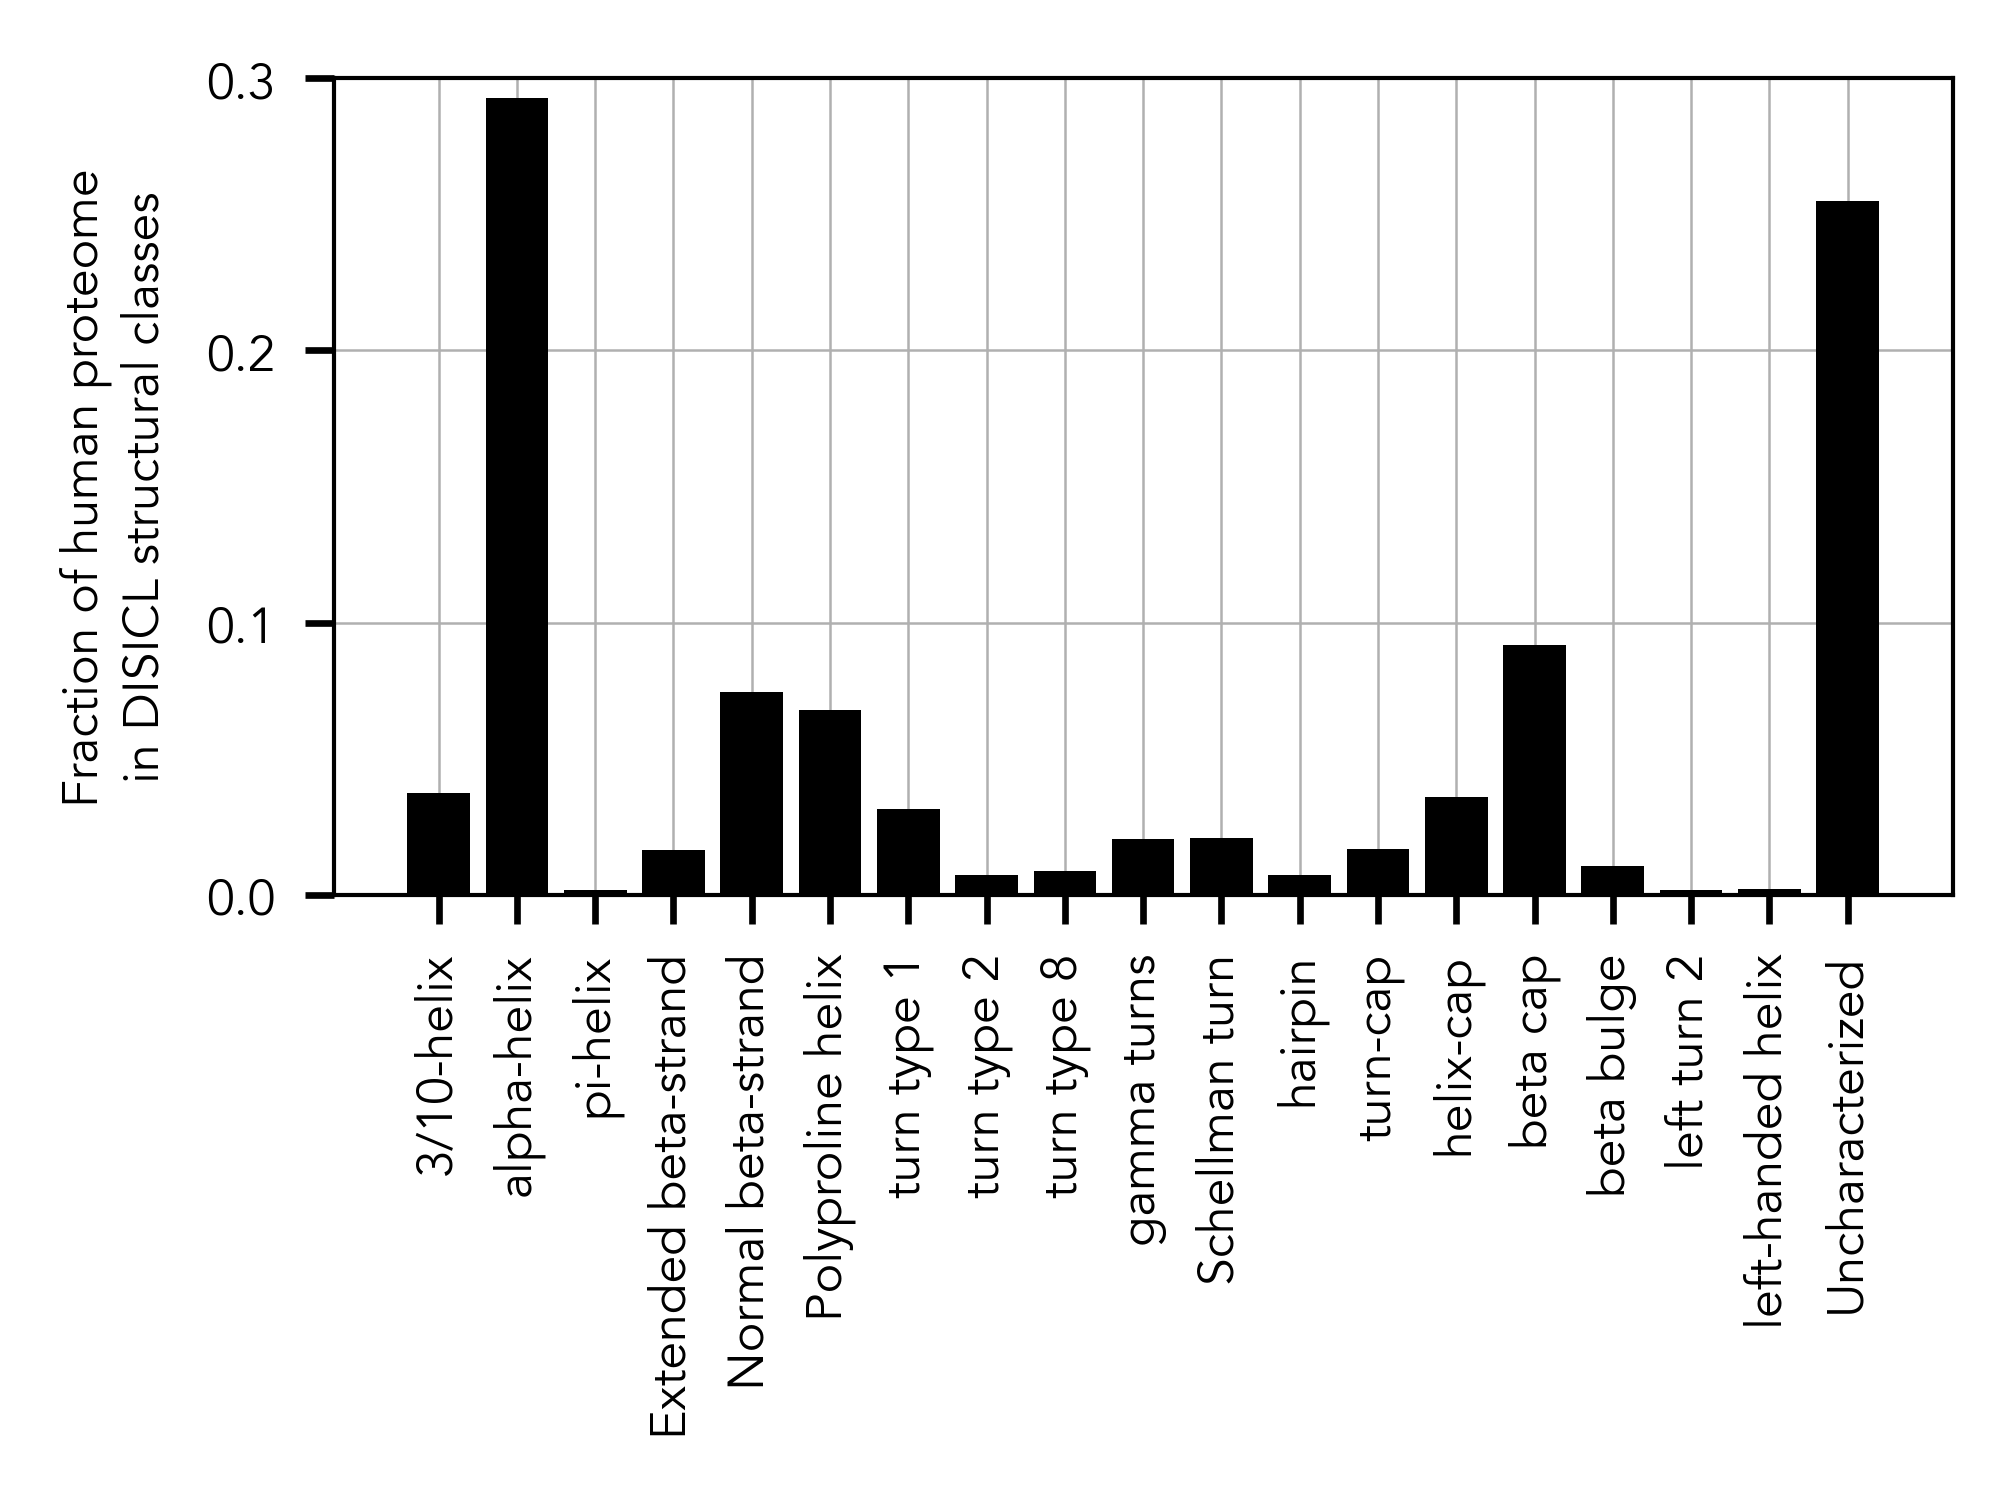

In [17]:
figure(None, (3.5,2.6), dpi=300)
plt.grid(zorder=-300, linewidth=0.3)
plt.bar(np.arange(0,len(DISICL_counts)), DISICL_counts, color='k', zorder=2)

plt.xticks(np.arange(0,len(DISICL_counts)), DISICL_NAMES,rotation=90, fontsize=6)
print('')
plt.ylabel('Fraction of human proteome\nin DISICL structural classes', fontsize=6)
plt.yticks(fontsize=6)

plt.ylim([0,0.3])
plt.tight_layout()
plt.savefig('../FIGURES/human_proteome_structural_classification.pdf')




### Write data for table S2

In [53]:
with open('../generated_data/ptm_counts_table_s2.tsv','w') as fh:
    for idx in range(len(ptm_counts_all)):
        fh.write(f'{sorted_names[idx]}\t {ptm_counts_all[idx]}\n')